## Loading Dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import xgboost as xgb

In [11]:
df_smenn=pd.read_csv('train_enn.csv')
df_dev=pd.read_csv('dev.csv')

In [12]:
X_train=df_smenn.drop('Output',axis=1)
y_train=df_smenn['Output']
X_dev=df_dev.drop('Output',axis=1)
y_dev=df_dev['Output']

## Scaling

In [13]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_dev= scaler.transform(X_dev)

## Baseline model: Logistic Regression

In [14]:
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train, y_train)
baseline_pred = baseline_model.predict(X_dev)
baseline_accuracy = accuracy_score(y_dev, baseline_pred)
baseline_f1 = f1_score(y_dev, baseline_pred, average='weighted')
print("Baseline (Logistic Regression) Accuracy:", baseline_accuracy)
print("Baseline (Logistic Regression) F1 Score:", baseline_f1)

Baseline (Logistic Regression) Accuracy: 0.6106585533418393
Baseline (Logistic Regression) F1 Score: 0.610892691676666


## Models to Compare

In [6]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_dev)
    accuracy = accuracy_score(y_dev,y_pred)
    f1 = f1_score(y_dev, y_pred, average='weighted')
    print(f"{name} Accuracy:", accuracy)
    print(f"{name} F1 Score:", f1)

Random Forest Accuracy: 0.7070370006870154
Random Forest F1 Score: 0.709593615374129
K-Nearest Neighbors Accuracy: 0.6284228089115713
K-Nearest Neighbors F1 Score: 0.6294502877223629
Decision Tree Accuracy: 0.65717931102169
Decision Tree F1 Score: 0.6593129003022655
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1899
[LightGBM] [Info] Number of data points in the train set: 37953, number of used features: 12
[LightGBM] [Info] Start training from score -1.030848
[LightGBM] [Info] Start training from score -1.407841
[LightGBM] [Info] Start training from score -0.919735
LightGBM Accuracy: 0.6734713907154775
LightGBM F1 Score: 0.6762440415819293
XGBoost Accuracy: 0.6919226616939838
XGBoost F1 Score: 0.694299529565727


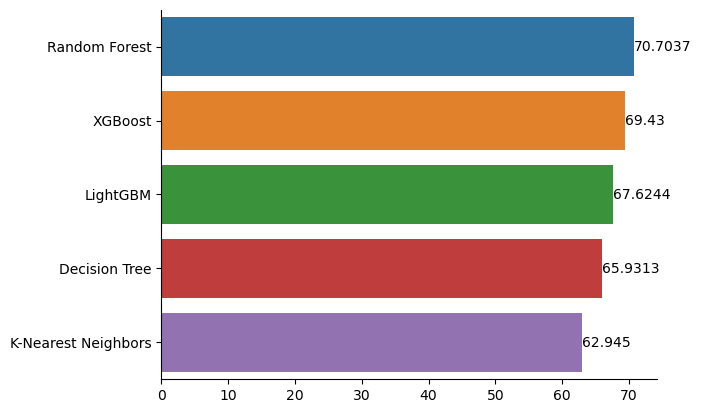

In [2]:
m = {
    "Random Forest": 0.7070370006870154*100,
    "K-Nearest Neighbors": 0.6294502877223629*100,
    "Decision Tree": 0.6593129003022655*100,
    "LightGBM":0.6762440415819293*100,
    "XGBoost": 0.694299529565727*100
}
m= dict(sorted(m.items(), key=lambda item: item[1],reverse=True))

ax=sns.barplot(y=list(m.keys()),x=list(m.values()))
sns.despine()
for i in ax.containers:
    ax.bar_label(i)

## Random Search

In [7]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=1234)
scorer = make_scorer(f1_score, average='weighted')

# Perform grid search with cross-validation
grid_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, 
                                   n_iter=10, cv=3, scoring=scorer, random_state=1234)
grid_search.fit(X_train, y_train)

results = grid_search.cv_results_
sorted_indices = results['mean_test_score'].argsort()[::-1]

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_dev)
best_accuracy = accuracy_score(y_dev, y_pred)
best_f1 = f1_score(y_dev, y_pred, average='weighted')

print("Best Parameters:", best_params)
print("Best Model Accuracy:", best_accuracy)
print("Best Model F1 Score:", best_f1)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Best Model Accuracy: 0.6984002355481401
Best Model F1 Score: 0.7009381708444862


## Bayesian Optimization

In [9]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Define the search space for hyperparameters
param_space = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(1, 50),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Categorical([None, 'sqrt', 'log2'])
}

# Initialize RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=1234)

# Define BayesSearchCV with F1 score as the optimization metric
opt = BayesSearchCV(estimator=rf_classifier, search_spaces=param_space, scoring='f1_weighted', n_iter=30, cv=3, n_jobs=-1)

# Fit the model
opt.fit(X_train, y_train)

# Get the best parameters and model
best_params = opt.best_params_
best_model = opt.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_dev)
best_f1 = f1_score(y_dev, y_pred, average='weighted')

print("Best Parameters:", best_params)
print("Best Model F1 Score:", best_f1)

Best Parameters: OrderedDict([('max_depth', 50), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)])
Best Model F1 Score: 0.7102151148057815


In [15]:
df_test=pd.read_csv('test.csv')
X_test=scaler.fit_transform(df_test.drop('Output',axis=1))
y_test=df_test['Output']

In [16]:
rf_classifier=RandomForestClassifier(random_state=1234,n_estimators=200,max_depth=38,max_features='sqrt',min_samples_leaf=1,min_samples_split=2)
rf_classifier.fit(X_train,y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy:", accuracy)
print(f"F1 Score:", f1)

Accuracy: 0.6190326633165829
F1 Score: 0.6242255956842823


In [17]:
rf_classifier=RandomForestClassifier(random_state=1234)
rf_classifier.fit(X_train,y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy:", accuracy)
print(f"F1 Score:", f1)

Accuracy: 0.6195822864321608
F1 Score: 0.624793623480136


## Final F1 Score: 0.624793623480136